In [54]:
Tuan Pham, Victoria Hall, Alexy Correa, Sahil Jain  

SyntaxError: invalid syntax (Temp/ipykernel_27328/3489103171.py, line 1)

# Final Project

We decide to do this project ....

In [115]:
import numpy as np
import pandas as pd
print("Imported libraries")

Imported libraries


# Data Prep
Here we clean up the raw data to use.

Data prep includes:
* Split Month/Day/Year column to 3 different columns
* Replace None values with 0  
* Removing "$" from the data set

In [129]:
# Data Cleaning
df = pd.read_csv('Unicorn_Companies.csv')

# Replace 4/17/2015 -> 3 separate columns on Month/Day/Year Joined
df[['Month Joined', 'Day Joined', 'Year Joined']] = df['Date Joined'].str.split('/', 3, expand=True)
df.drop('Date Joined', axis=1, inplace=True)

# Replace Nones in Numerical Data with 0
# Did not do it for 'Financial Stage' since it's categorical
df['Portfolio Exits'] = df['Portfolio Exits'].replace('None', 0)
df['Total Raised'] = df['Total Raised'].replace('None', '$0M')
df['Investors Count'] = df['Investors Count'].replace('None', 0)
df['Valuation ($B)'] = df['Valuation ($B)'].replace('None', '$0')
df['Founded Year'] = df['Founded Year'].replace('None', 0) # I say we kick these entries out but I'm leaving it at 0 for now
df['Deal Terms'] = df['Deal Terms'].replace('None', 0)

# Removed $ from data
df['Valuation ($B)'] = df['Valuation ($B)'].str[1:]

# Convert $M and $B to just $M
df['Total Raised ($M)'] = df['Total Raised'].str[1:-1]
df['Total Raised ($M)'] = pd.to_numeric(df['Total Raised ($M)'])
df.loc[df['Total Raised'].str[-1] == 'B', 'Total Raised ($M)'] *= 1000
df.drop('Total Raised', axis=1, inplace=True)

# Convert numerical data into floats/ints
df[['Valuation ($B)', 'Founded Year', 'Investors Count']] = df[['Valuation ($B)', 'Founded Year', 'Investors Count']].apply(pd.to_numeric)
df[['Deal Terms', 'Portfolio Exits', 'Month Joined']] = df[['Deal Terms', 'Portfolio Exits', 'Month Joined']].apply(pd.to_numeric)
df[['Day Joined', 'Year Joined', 'Total Raised ($M)']] = df[['Day Joined', 'Year Joined', 'Total Raised ($M)']].apply(pd.to_numeric)

df.head()

,Company,Valuation ($B),Country,City,Industry,Select Inverstors,Founded Year,Financial Stage,Investors Count,Deal Terms,Portfolio Exits,Month Joined,Day Joined,Year Joined,Total Raised ($M)
0,Bytedance,140.0,China,Beijing,Artificial intelligence,"Sequoia Capital China, SIG Asia Investments, S...",2012,IPO,28,8,5,4,7,2017,7440.0
1,SpaceX,100.3,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen...",2002,None,29,12,0,12,1,2012,6874.0
2,Stripe,95.0,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG",2010,Asset,39,12,1,1,23,2014,2901.0
3,Klarna,45.6,Sweden,Stockholm,Fintech,"Institutional Venture Partners, Sequoia Capita...",2005,Acquired,56,13,1,12,12,2011,3472.0
4,Epic Games,42.0,United States,Cary,Other,"Tencent Holdings, KKR, Smash Ventures",1991,Acquired,25,5,2,10,26,2018,4377.0


# Data Exploration
mean, median, mode, range....
Printing graphs, boxplot, distributions...
categorical varibles to frequency table
correlation for continuous



----------- Valuation ($B) -----------

3.2920829315332583
1.6
140.0
1.0


<AxesSubplot:>

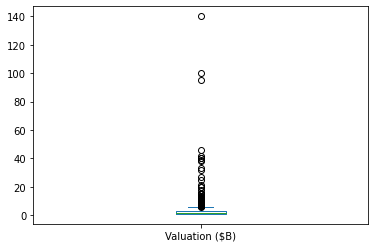

In [130]:
print("\n----------- Valuation ($B) -----------\n")
print(df['Valuation ($B)'].mean())
print(df['Valuation ($B)'].median())
print(df['Valuation ($B)'].max())
print(df['Valuation ($B)'].min())
# df['Valuation ($B)'].value_counts().plot.bar()
df.dtypes
df['Valuation ($B)'].plot(x='class', kind='box')


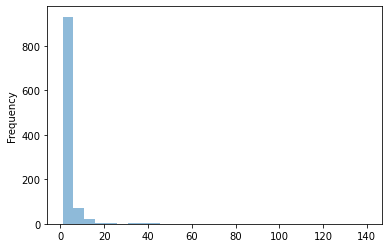

In [131]:
ax = df['Valuation ($B)'].plot.hist(bins=28, alpha=0.5)
# after seeing the distribution, we decided to only use compnies with valuation less than $2B

In [132]:
df = df[df['Valuation ($B)'] <= 2]
print(df.shape)
# df.head()

(645, 15)


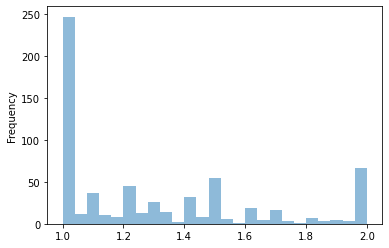

In [133]:
ax = df['Valuation ($B)'].plot.hist(bins=25, alpha=0.5)


----------- Investors Count -----------

mean:  12.655813953488373
median:  11.0
max:  91
min:  0
whisker:  29.5


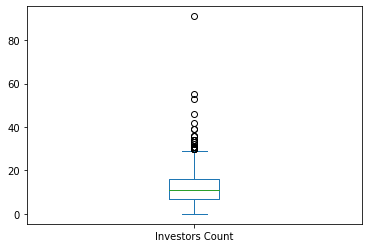

In [134]:
# now we can look at other catergories
print("\n----------- Investors Count -----------\n")
print("mean: ",df['Investors Count'].mean())
print("median: ",df['Investors Count'].median())
print("max: ",df['Investors Count'].max())
print("min: ",df['Investors Count'].min())
# df['Investors Count'].value_counts().plot.bar()
df['Investors Count'].plot(x='class', kind='box')

# Note after seeing the boxplot, we decided to take up to the maximum in whisker boxplot...
whisker = 1.5 * (df['Investors Count'].quantile(.75) - df['Investors Count'].quantile(.25))
whisker += df['Investors Count'].quantile(.75)
print("whisker: ", whisker)
df = df[df['Investors Count'] <= 29.5]



<AxesSubplot:>

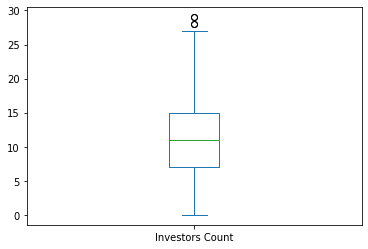

In [135]:
df = df[df['Investors Count'] <= 29.5]
df['Investors Count'].plot(x='class', kind='box')

<AxesSubplot:xlabel='Industry'>

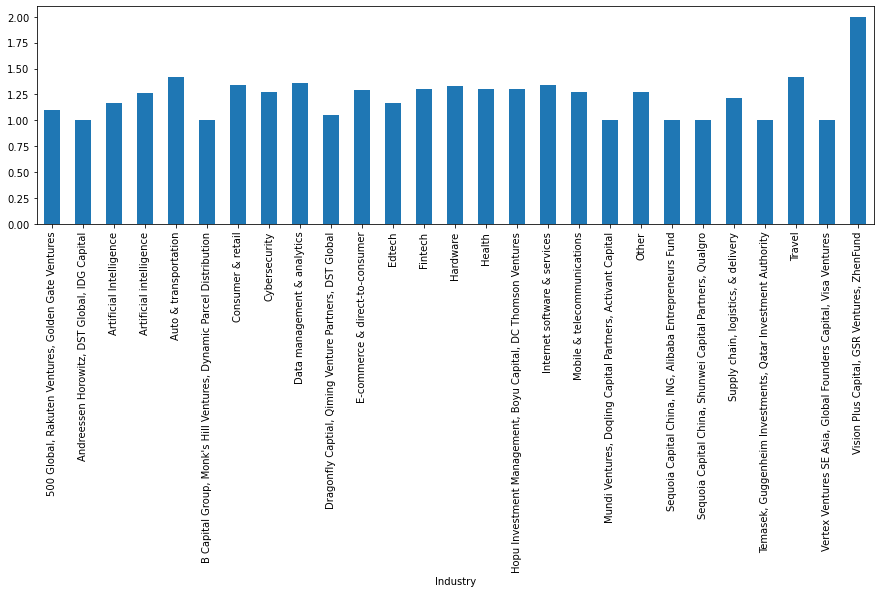

In [143]:
# relationship between valuation vs ... country, industry, year founded
df.groupby(['Industry'])['Valuation ($B)'].mean().plot.bar(figsize=(15,4))

<AxesSubplot:xlabel='Founded Year'>

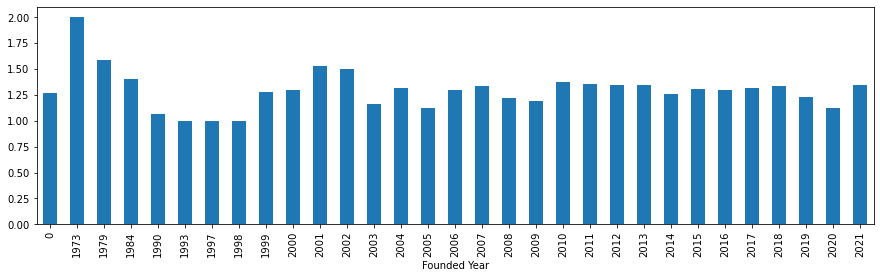

In [142]:
df.groupby(['Founded Year'])['Valuation ($B)'].mean().plot.bar(figsize=(15,4))

<AxesSubplot:xlabel='Country'>

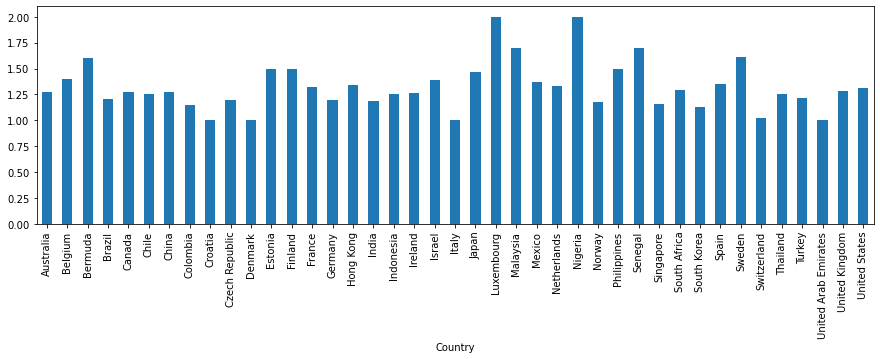

In [141]:
df.groupby(['Country'])['Valuation ($B)'].mean().plot.bar(figsize=(15,4))

# Feature Engineering
One hot encoding?
Feature scaling
what do with noise/outliers, binning, imputation, transforamtion?
dimension reduction
PCA
....


# 	Data Analysis: 
decision tree, 
k means,
knn
naive bayes 
....